## Структура файла
#### Поиск оптимального портфеля
- Скачивание данных по ряду активов: голубые фишки, безрисковые инвестиции в гос. облигации
- Генерация случайных портфелей, их оценка. Построение Допустимого множества инвестиционных альтернатив
- Поиск эффективной границы множества
- Выбор оптимального портфеля, исходя из предпосылок об отношении к риску индивидов

#### Генерация траекторий цен активов на 20 лет
- Geometric Brownian Motion 
- Monte Carlo simulations с сохранением параметров активов

#### Вычисление распределения доходности нашего портфеля
- Написание инвестиционной стратегии в виде скрипта: 
- - Покупка новых активов при поступлении денег
- - Ребалансировка портфеля в соответствии с найденным оптимумом
- Вычисление доходности портфеля на основе сгенерированных рядов цен

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from portfolio_optimization import PortfolioOptimization

In [59]:
import numpy as np
import pandas as pd
from tqdm import tqdm
# from pandas_datareader import data

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from copy import deepcopy

import pandas_datareader as pdr

In [60]:
stocks = np.array(
    ['GAZP', 'GEMC', 'YNDX', 'VKCO', 'POSI', 'FLOT', 'UNAC', 'NMTP', 'FESH', 'PIKK', 'AFLT',
     'DSKY', 'MVID', 'MGNT', 'OZON', 'POLY', 'ALRS', 'NLMK', 'PHOR', 'MTSS', 'SBER', 'TCSG', 
     'IRAO', 'NVTK', 'ROSN', 'FIVE', 'GMKN', 'LKOH', 'PLZL', 'SNGS', 'TATN']
)
stocks.astype(str)

mask = np.argwhere(
    np.isin(
        stocks, ['GEMC', 'VKCO', 'POSI', 'FLOT', 'TCSG', 'OZON']
    )
)

stocks = np.delete(stocks, mask)
stocks

array(['GAZP', 'YNDX', 'UNAC', 'NMTP', 'FESH', 'PIKK', 'AFLT', 'DSKY',
       'MVID', 'MGNT', 'POLY', 'ALRS', 'NLMK', 'PHOR', 'MTSS', 'SBER',
       'IRAO', 'NVTK', 'ROSN', 'FIVE', 'GMKN', 'LKOH', 'PLZL', 'SNGS',
       'TATN'], dtype='<U4')

In [61]:
portOpt = PortfolioOptimization(stocks)

In [62]:
'''
import warnings
warnings.filterwarnings('ignore')

portOpt.make_stock_table('31-10-2018', '31-10-2023')
print(portOpt.df_assets)
print()
print(portOpt.df_benchmark)
'''

KeyboardInterrupt: 

In [64]:
portOpt.df_assets = pd.read_csv('raw/df_assets1.csv')
portOpt.df_benchmark = pd.read_csv('raw/df_benchmark1.csv')

In [65]:
portOpt.df_assets
portOpt.df_assets['TRADEDATE'] = pd.to_datetime(portOpt.df_assets['TRADEDATE'])
portOpt.df_assets.set_index('TRADEDATE', inplace=True)
portOpt.df_assets

,GAZP,YNDX,UNAC,NMTP,FESH,PIKK,AFLT,DSKY,MVID,MGNT,...,SBER,IRAO,NVTK,ROSN,FIVE,GMKN,LKOH,PLZL,SNGS,TATN
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2018-10-31,155.47,1916.5,0.8090,6.135,4.990,352.3,97.25,89.50,398.5,3590.0,...,189.80,3.9820,1049.8,460.45,1539.0,11000.0,4945.0,4152.0,26.570,784.4
2018-11-01,153.50,1999.0,0.8230,6.150,5.055,353.7,96.88,90.38,401.7,3640.0,...,188.67,3.9985,1082.1,460.00,1598.5,11250.0,4937.0,4148.5,26.500,779.0
2018-11-02,153.71,1995.0,0.8270,6.185,5.110,353.2,101.78,90.76,407.0,3660.0,...,192.60,3.9445,1080.4,459.60,1614.5,11470.0,4980.0,4185.0,26.685,792.7
2018-11-06,156.00,2002.0,0.8480,6.315,5.125,353.4,102.40,90.50,404.9,3695.0,...,197.80,4.0000,1081.6,482.45,1629.5,11565.0,5055.0,4214.0,27.030,802.2
2018-11-07,157.85,1995.0,0.8550,6.525,5.090,351.2,100.60,90.30,407.2,3720.0,...,201.90,4.0245,1103.8,484.10,1640.0,11695.0,5174.5,4247.0,27.305,814.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,169.62,2737.0,1.8785,12.895,95.680,751.0,40.87,71.42,199.9,6046.5,...,273.73,4.5000,1695.0,590.50,2414.5,17460.0,7437.5,11756.0,33.240,622.3
2023-10-26,168.45,2682.4,1.8080,12.640,93.710,742.4,39.98,71.42,195.9,5913.0,...,269.90,4.3735,1682.0,583.00,2372.0,17250.0,7228.5,11577.0,32.575,613.6
2023-10-27,167.26,2666.6,1.8085,12.620,93.140,730.9,40.26,71.42,192.8,6015.0,...,269.70,4.3785,1678.4,594.60,2366.0,17506.0,7318.0,11726.0,32.785,622.4


In [66]:
portOpt.df_benchmark
portOpt.df_benchmark['TRADEDATE'] = pd.to_datetime(portOpt.df_benchmark['TRADEDATE'])
portOpt.df_benchmark.set_index('TRADEDATE', inplace=True)
portOpt.df_benchmark

,IMOEX
TRADEDATE,
2018-10-31,2352.71
2018-11-01,2359.33
2018-11-02,2377.95
2018-11-06,2412.31
2018-11-07,2445.34
...,...
2023-10-25,3265.28
2023-10-26,3223.89
2023-10-27,3224.18


In [ ]:
#portOpt.df_assets.to_csv('df_assets1.csv', sep=',')
#portOpt.df_assets.to_csv('df_assets2.csv', sep=';')

#portOpt.df_benchmark.to_csv('df_benchmark1.csv', sep=',')
#portOpt.df_benchmark.to_csv('df_benchmark2.csv', sep=';')

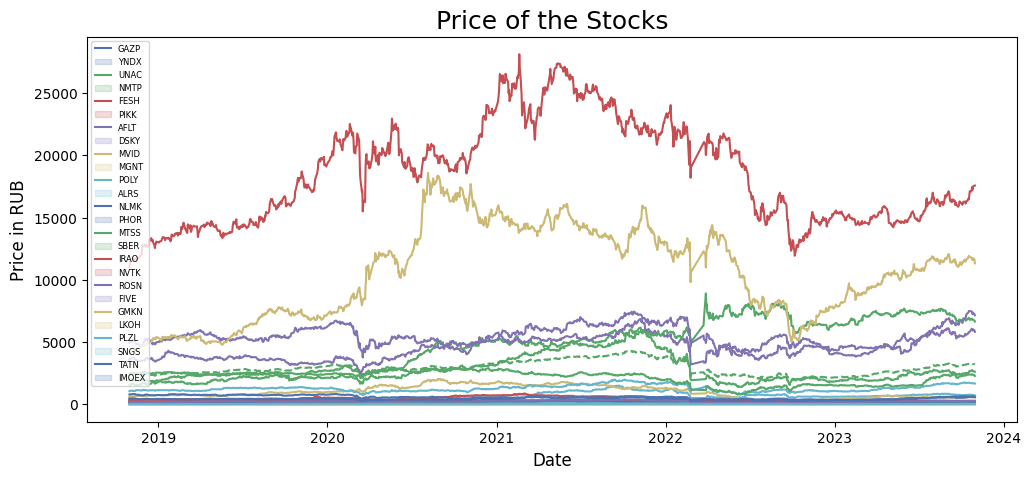

In [67]:
portOpt.plot_stock_performance()

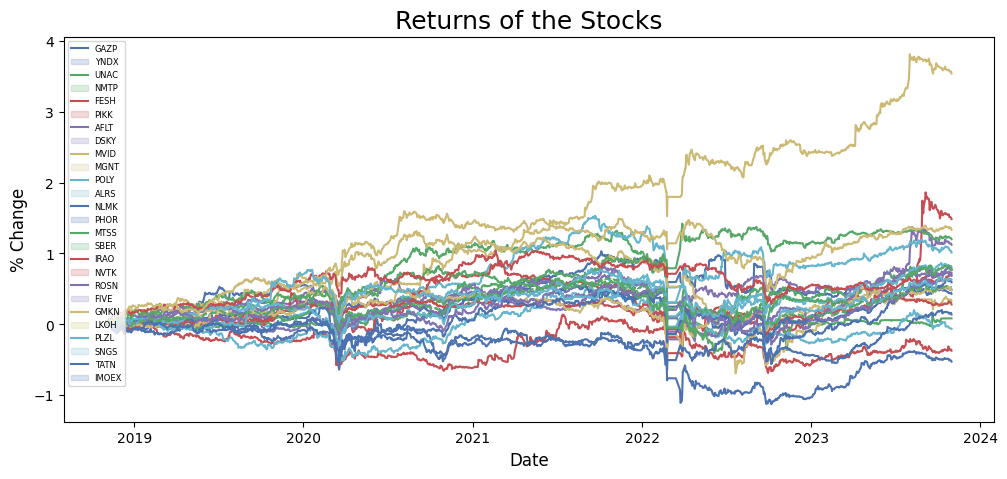

In [68]:
portOpt.plot_stock_return_performance()

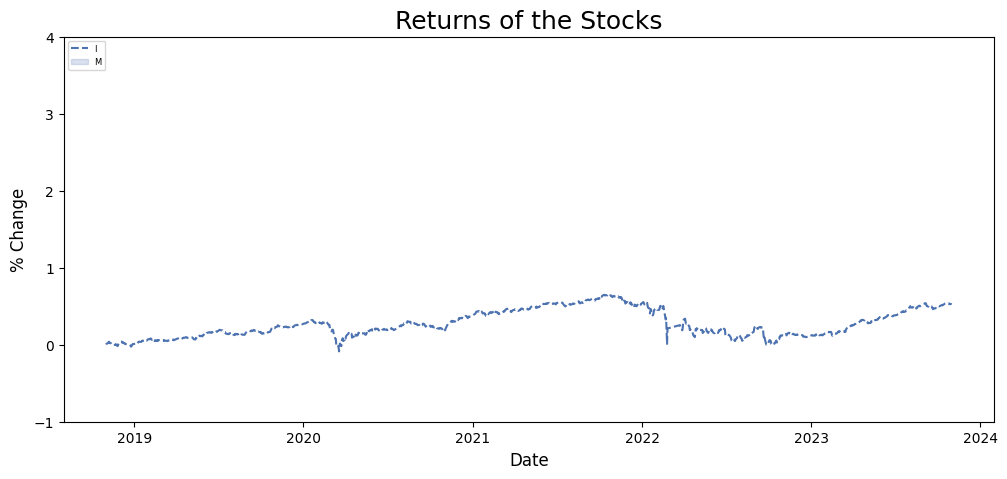

In [69]:
benchmark_returns = portOpt.df_benchmark.pct_change()[1:].cumsum()

plt.figure(figsize=(12, 5))
sns.lineplot(data=benchmark_returns[portOpt.benchmark], label=portOpt.benchmark, linestyle='--')
plt.title('Returns of the Stocks', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('% Change', fontsize=12)
plt.ylim((-1, 4))
plt.legend(portOpt.benchmark, loc='upper left', prop={'size': 6})
plt.show();

## Построение портфеля

### Предпосылки

1. Не имеем доступа к зарубежным рынкам (по крайней мере в краткосрочной перспективе)
   
   - минимизируем политические риски заморозки активов
   - семья не имеет финансового образования и опыта в торговле на финансовых рынках, поэтому торговля на зарубежных рынках сопряжена и с бОльшими финансовыми рисками

<br>

2. Инвестируем в следующие классы активов: акции, облигации, депозиты, commodities?
   
   - деривативы являются более рисковым финансовым инструментом по сравнению с "более классическими" активами и в основном используются при построении стратегий ??
   - в семье нет квалифицированных инвесторов (если мы только рекомендуем активы, то ок; если же мы занимаемся доверительным управлением, то лажа)
   - насколько я понимаю, торговля commodities доступна только через фьючерсы, а этот фин. инструмент не доступен не квалифицированным инвесторам (или людям, прошедшим тест на знание соответствующих фин. инструментов)

<br>

3. Соотношение активов в портфеле: ? / ? / ? (...)
   
   - ...
   - ...

<br>

4. ERP = 6.5% &mdash; 
5. RFR = 11.92% &mdash; 

### Подбор оптимальных весов

In [70]:
portOpt.calc_stock_returns()
print(portOpt.df_assets_performance)
print()
print(portOpt.df_benchmark_performance)

                GAZP      YNDX      UNAC      NMTP      FESH      PIKK  \
TRADEDATE                                                                
2018-11-01 -0.012671  0.043047  0.017305  0.002445  0.013026  0.003974   
2018-11-02  0.001368 -0.002001  0.004860  0.005691  0.010880 -0.001414   
2018-11-06  0.014898  0.003509  0.025393  0.021019  0.002935  0.000566   
2018-11-07  0.011859 -0.003497  0.008255  0.033254 -0.006829 -0.006225   
2018-11-08 -0.002154 -0.006516 -0.019883  0.016858 -0.001965  0.007403   
...              ...       ...       ...       ...       ...       ...   
2023-10-25 -0.003349  0.004330  0.008861 -0.008077  0.002515 -0.010801   
2023-10-26 -0.006898 -0.019949 -0.037530 -0.019775 -0.020589 -0.011451   
2023-10-27 -0.007064 -0.005890  0.000277 -0.001582 -0.006083 -0.015490   
2023-10-30 -0.000598 -0.023626 -0.010229  0.000792  0.001288 -0.012177   
2023-10-31  0.004307  0.003226 -0.020670 -0.017419 -0.029809 -0.020083   

                AFLT      DSKY      M

In [71]:
portOpt.calc_betas()

{'GAZP': 1.0148470466258723,
 'YNDX': 0.8808830592067717,
 'UNAC': 0.8834809575670431,
 'NMTP': 0.7591531145469285,
 'FESH': 0.8724556462129168,
 'PIKK': 0.5459634670470995,
 'AFLT': 0.8031416414969232,
 'DSKY': 0.6106766904696278,
 'MVID': 0.7364391056768474,
 'MGNT': 0.7241683538942819,
 'POLY': 0.5652621777028686,
 'ALRS': 0.7463701421759776,
 'NLMK': 0.6456432749174855,
 'PHOR': 0.2925525688659141,
 'MTSS': 0.6145596624290544,
 'SBER': 1.0478073022734966,
 'IRAO': 1.0045635585412878,
 'NVTK': 0.897325123067143,
 'ROSN': 1.0580175978451438,
 'FIVE': 0.7135465144271248,
 'GMKN': 0.6585320962191579,
 'LKOH': 0.9176250591405171,
 'PLZL': 0.5739055022899933,
 'SNGS': 0.9213125008803515,
 'TATN': 1.039295231826801}

In [72]:
portOpt.check_beta_sustainability()

,daily_beta,monthly_1_beta,monthly_last_beta,monthly_avg_beta,monthly_cumulative_beta
GAZP,1.0148,0.9286,0.8468,0.8455,0.9981
YNDX,0.8809,0.6593,0.2174,1.2367,1.3227
UNAC,0.8835,0.5189,0.7957,1.8732,1.2356
NMTP,0.7592,0.6542,0.3736,1.1851,1.1250
FESH,0.8725,0.5959,0.2484,1.2286,1.1111
PIKK,0.5460,0.8334,0.2650,1.1602,1.1324
AFLT,0.8031,0.4735,0.1927,1.1768,1.3881
DSKY,0.6107,0.5736,0.1629,0.6828,0.8465
MVID,0.7364,0.8790,0.1999,0.8729,1.0795
MGNT,0.7242,0.5387,0.2325,1.2221,1.0738


In [73]:
portOpt.df_all_betas.describe()

,daily_beta,monthly_1_beta,monthly_last_beta,monthly_avg_beta,monthly_cumulative_beta
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.781104,0.712200,0.304564,1.073308,1.063148
std,0.192046,0.247517,0.178666,0.324674,0.258212
min,0.292600,0.130600,0.086100,0.419600,0.637600
25%,0.645600,0.538700,0.199900,0.845500,0.846500
50%,0.759200,0.724200,0.258100,1.121400,1.111100
75%,0.917600,0.879000,0.371500,1.228600,1.195200
max,1.058000,1.133300,0.846800,1.873200,1.560400


In [74]:
portOpt.calc_expected_returns()

GAZP    17.41575
YNDX    19.95855
UNAC    24.09580
NMTP    19.62315
FESH    19.90590
PIKK    19.46130
AFLT    19.56920
DSKY    16.35820
MVID    17.59385
MGNT    19.86365
POLY    18.87240
ALRS    19.29230
NLMK    14.64740
PHOR    20.24455
MTSS    16.79630
SBER    20.26535
IRAO    16.51810
NVTK    20.51690
ROSN    23.18515
FIVE    19.20910
GMKN    15.85510
LKOH    18.87370
PLZL    17.33320
SNGS    18.40115
TATN    18.55650
Name: monthly_avg_beta, dtype: float64

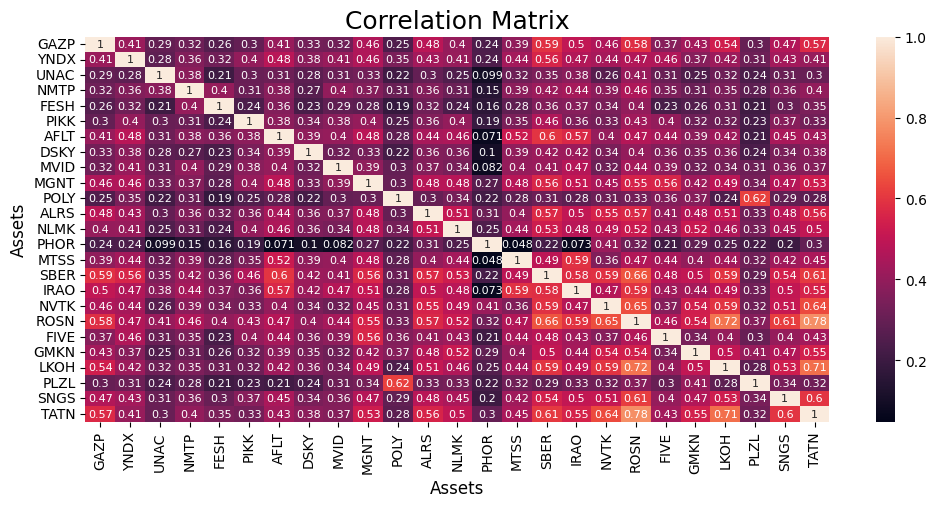

In [75]:
portOpt.make_corr_mat()

In [76]:
portOpt.calc_cov_matrix()

### Максимизация коэффициента Шарпа

In [77]:
portOpt.calc_opt_stock_weights()

{'GAZP': 0.0,
 'YNDX': 0.0,
 'UNAC': 0.11139,
 'NMTP': 0.01623,
 'FESH': 0.01255,
 'PIKK': 0.09474,
 'AFLT': 0.08059,
 'DSKY': 0.0,
 'MVID': 0.0,
 'MGNT': 0.04158,
 'POLY': 0.02657,
 'ALRS': 0.0,
 'NLMK': 0.0,
 'PHOR': 0.42314,
 'MTSS': 0.0,
 'SBER': 0.0,
 'IRAO': 0.0,
 'NVTK': 0.0,
 'ROSN': 0.1932,
 'FIVE': 0.0,
 'GMKN': 0.0,
 'LKOH': 0.0,
 'PLZL': 0.0,
 'SNGS': 0.0,
 'TATN': 0.0}

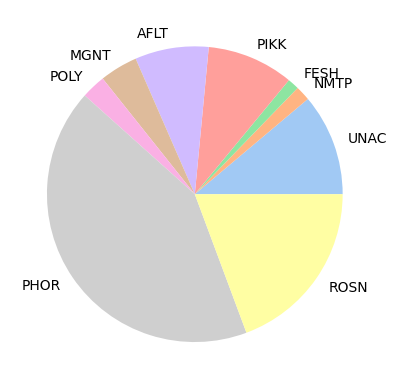

In [78]:
portOpt.make_pie_graph_weights()

In [79]:
portOpt.cleaned_opt_stock_weights

{'UNAC': 0.11139,
 'NMTP': 0.01623,
 'FESH': 0.01255,
 'PIKK': 0.09474,
 'AFLT': 0.08059,
 'MGNT': 0.04158,
 'POLY': 0.02657,
 'PHOR': 0.42314,
 'ROSN': 0.1932}

In [80]:
portOpt.calc_stock_portfolio_performance()

Expected annual return: 21.0%
Annual volatility: 23.7%
Sharpe Ratio: 0.39


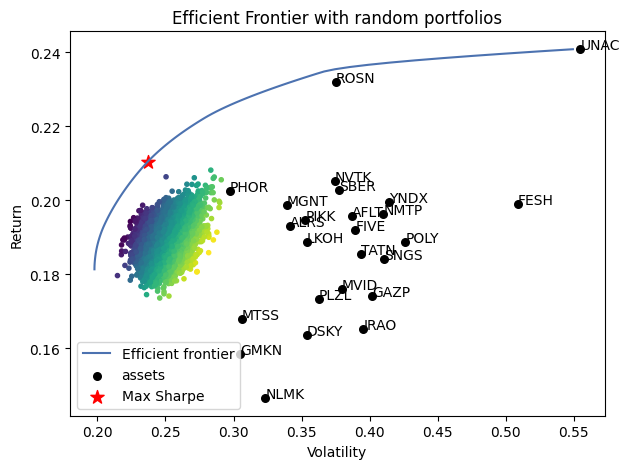

In [81]:
portOpt.plot_efficient_frontier()

In [ ]:
'''
portOpt.save_plot_efficient_frontier(path = "./pics/frontier_7dec.pdf")
'''

### Максимизация функции полезности с параметром `gamma = 3`

In [82]:
portOpt.exp_returns_with_bond = portOpt.exp_returns.copy()
portOpt.exp_returns_with_bond = portOpt.exp_returns_with_bond.append(
    pd.Series({'Bond': portOpt.rfr})
)
portOpt.exp_returns_with_bond

GAZP    0.174158
YNDX    0.199585
UNAC    0.240958
NMTP    0.196232
FESH    0.199059
PIKK    0.194613
AFLT    0.195692
DSKY    0.163582
MVID    0.175938
MGNT    0.198636
POLY    0.188724
ALRS    0.192923
NLMK    0.146474
PHOR    0.202446
MTSS    0.167963
SBER    0.202653
IRAO    0.165181
NVTK    0.205169
ROSN    0.231852
FIVE    0.192091
GMKN    0.158551
LKOH    0.188737
PLZL    0.173332
SNGS    0.184011
TATN    0.185565
Bond    0.119200
dtype: float64

In [83]:
portOpt.assets_cov_with_bond = portOpt.assets_cov.copy()
portOpt.assets_cov_with_bond['Bond'] = 0
portOpt.assets_cov_with_bond.loc['Bond'] = 0
portOpt.assets_cov_with_bond

,GAZP,YNDX,UNAC,NMTP,FESH,PIKK,AFLT,DSKY,MVID,MGNT,...,IRAO,NVTK,ROSN,FIVE,GMKN,LKOH,PLZL,SNGS,TATN,Bond
GAZP,0.161681,0.068892,0.064755,0.052528,0.053909,0.041938,0.064059,0.046990,0.049148,0.062674,...,0.079677,0.068888,0.087856,0.058380,0.053174,0.076169,0.043793,0.076910,0.090141,0
YNDX,0.068892,0.171887,0.064953,0.061536,0.067526,0.058510,0.077419,0.055838,0.064893,0.065330,...,0.076458,0.068480,0.072393,0.074953,0.047235,0.061503,0.047330,0.073703,0.066431,0
UNAC,0.064755,0.064953,0.307936,0.086920,0.058606,0.059030,0.067553,0.054196,0.065088,0.062005,...,0.083658,0.054923,0.085875,0.066029,0.042016,0.062067,0.048010,0.070213,0.065923,0
NMTP,0.052528,0.061536,0.086920,0.168084,0.084300,0.045137,0.060113,0.038590,0.061570,0.050952,...,0.071621,0.059198,0.070521,0.056021,0.038595,0.050860,0.041939,0.060584,0.063735,0
FESH,0.053909,0.067526,0.058606,0.084300,0.258928,0.042758,0.071522,0.042049,0.055068,0.047588,...,0.075321,0.065673,0.076398,0.046021,0.040191,0.056361,0.037989,0.063237,0.069985,0
PIKK,0.041938,0.058510,0.059030,0.045137,0.042758,0.124495,0.052540,0.042700,0.050324,0.048189,...,0.049648,0.044026,0.057012,0.054764,0.034185,0.039335,0.028923,0.054080,0.045597,0
AFLT,0.064059,0.077419,0.067553,0.060113,0.071522,0.052540,0.149699,0.053902,0.059438,0.063624,...,0.086483,0.058325,0.068860,0.066327,0.045436,0.057988,0.030017,0.070957,0.065384,0
DSKY,0.046990,0.055838,0.054196,0.038590,0.042049,0.042700,0.053902,0.125071,0.042765,0.039971,...,0.058658,0.045436,0.053051,0.049890,0.037239,0.045552,0.030204,0.049720,0.053121,0
MVID,0.049148,0.064893,0.065088,0.061570,0.055068,0.050324,0.059438,0.042765,0.143973,0.050472,...,0.070916,0.044792,0.062487,0.057519,0.036848,0.045204,0.043266,0.056723,0.054631,0
MGNT,0.062674,0.065330,0.062005,0.050952,0.047588,0.048189,0.063624,0.039971,0.050472,0.115073,...,0.068296,0.057100,0.070293,0.073835,0.043486,0.058746,0.041230,0.065905,0.070531,0


In [88]:
portOpt.calc_opt_stock_weights_utility()

{'GAZP': 0.0,
 'YNDX': 0.0,
 'UNAC': 0.06032,
 'NMTP': 0.00879,
 'FESH': 0.0068,
 'PIKK': 0.0513,
 'AFLT': 0.04364,
 'DSKY': 0.0,
 'MVID': 0.0,
 'MGNT': 0.02251,
 'POLY': 0.01439,
 'ALRS': 0.0,
 'NLMK': 0.0,
 'PHOR': 0.22911,
 'MTSS': 0.0,
 'SBER': 0.0,
 'IRAO': 0.0,
 'NVTK': 0.0,
 'ROSN': 0.10461,
 'FIVE': 0.0,
 'GMKN': 0.0,
 'LKOH': 0.0,
 'PLZL': 0.0,
 'SNGS': 0.0,
 'TATN': 0.0,
 'Bond': 0.45854}

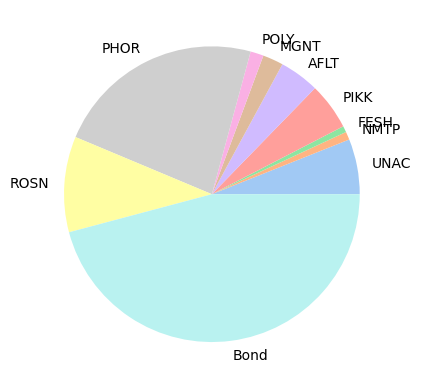

In [89]:
portOpt.make_pie_graph_weights(util=True)

In [90]:
portOpt.cleaned_opt_weights_utility

{'UNAC': 0.06032,
 'NMTP': 0.00879,
 'FESH': 0.0068,
 'PIKK': 0.0513,
 'AFLT': 0.04364,
 'MGNT': 0.02251,
 'POLY': 0.01439,
 'PHOR': 0.22911,
 'ROSN': 0.10461,
 'Bond': 0.45854}

In [91]:
portOpt.calc_stock_portfolio_performance(util=True)

Expected annual return: 16.9%
Annual volatility: 12.8%
Sharpe Ratio: 0.39


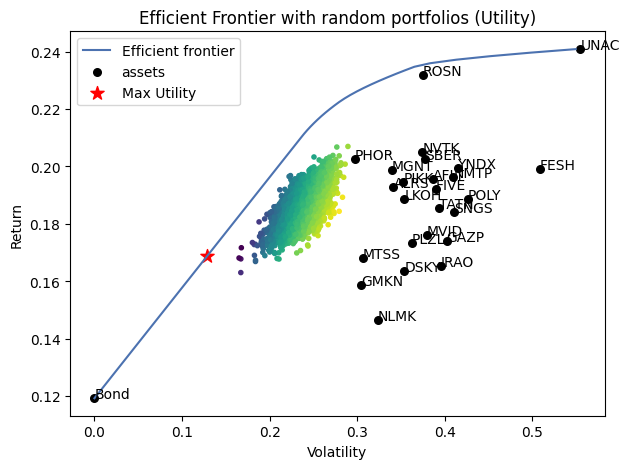

In [92]:
portOpt.plot_efficient_frontier(util=True)

# Генерация траекторий цен активов

In [16]:
cleaned_opt_weights = {
    'UNAC': 0.11139,
    'NMTP': 0.01623,
    'FESH': 0.01255,
    'PIKK': 0.09474,
    'AFLT': 0.08059,
    'MGNT': 0.04158,
    'POLY': 0.02657,
    'PHOR': 0.42314,
    'ROSN': 0.1932
}
for stock in df_assets_monthly.columns:
    if cleaned_opt_weights.get(stock, 0) == 0:
        cleaned_opt_weights[stock] = 0
cleaned_opt_weights

{'UNAC': 0.11139,
 'NMTP': 0.01623,
 'FESH': 0.01255,
 'PIKK': 0.09474,
 'AFLT': 0.08059,
 'MGNT': 0.04158,
 'POLY': 0.02657,
 'PHOR': 0.42314,
 'ROSN': 0.1932,
 'GAZP': 0,
 'YNDX': 0,
 'DSKY': 0,
 'MVID': 0,
 'ALRS': 0,
 'NLMK': 0,
 'MTSS': 0,
 'SBER': 0,
 'IRAO': 0,
 'NVTK': 0}

In [4]:
df_assets = pd.read_csv('assets.txt')
df_assets['Year month'] = df_assets['TRADEDATE'].apply(lambda x: x[:-2])
df_assets
df_assets.set_index('TRADEDATE', drop = True, inplace = True)
df_assets_monthly = df_assets.drop_duplicates(subset='Year month', keep = 'last')
df_assets_monthly.drop('Year month', axis = 1, inplace = True)
df_assets_monthly

C:\Users\Anton\AppData\Local\Temp\ipykernel_4716\1381394524.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_assets_monthly.drop('Year month', axis = 1, inplace = True)


,GAZP,YNDX,UNAC,NMTP,FESH,PIKK,AFLT,DSKY,MVID,MGNT,POLY,ALRS,NLMK,PHOR,MTSS,SBER,IRAO,NVTK,ROSN
TRADEDATE,,,,,,,,,,,,,,,,,,,
2018-10-31,155.47,1916.5,0.8090,6.135,4.990,352.3,97.25,89.50,398.5,3590.0,608.0,99.90,160.42,2470.0,257.60,189.80,3.9820,1049.8,460.45
2018-11-30,161.29,1965.0,0.7760,6.830,4.925,351.1,114.40,93.50,418.2,3500.0,667.3,99.63,158.36,2593.0,247.55,194.00,4.0950,1127.2,423.10
2018-12-29,153.50,1930.0,0.7880,6.850,4.710,376.3,101.18,90.44,410.0,3511.5,731.2,98.62,157.42,2546.0,238.00,186.30,3.8795,1132.0,432.50
2019-01-31,162.82,2212.0,0.8070,6.920,5.495,352.0,107.92,90.90,400.6,4155.0,746.9,98.56,152.02,2583.0,260.75,217.90,3.8250,1145.0,411.25
2019-02-28,158.99,2208.0,0.7030,7.450,5.065,359.0,97.10,88.92,412.0,3780.0,778.0,95.10,158.44,2555.0,253.00,207.80,3.9150,1080.4,398.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,166.86,2439.6,0.7515,9.770,66.250,758.3,42.70,71.26,190.2,5156.0,523.4,70.30,172.74,7310.0,296.75,239.61,4.0370,1335.0,482.35
2023-07-31,174.33,2635.0,0.7780,10.275,88.100,783.9,45.63,70.58,218.3,5797.5,NaN,85.50,211.44,7548.0,290.10,267.40,4.1605,1519.4,508.75
2023-08-31,177.99,2689.0,1.9895,15.100,109.440,827.0,44.02,68.18,196.0,6080.0,NaN,81.27,204.30,7314.0,284.10,264.85,4.1920,1684.8,556.15


In [5]:
def simulate_stock_prices(
        stockData:pd.DataFrame, 
        mc_sims:int, 
        time_periods:int, 
        dt=1.0
        ) -> np.ndarray:
    """
    Arguments
    ----------
    stocksData : pd.DataFrame
        DataFrame with stock Close prices,
    mc_sims : int
        number of trajectories to simulate
    time_periods : int
        number of periods to predict
    dt : flaot
        equals to 1 by default as mean return and covarince matrix is calculated inside the function

    Returns
    -------
    price_predict : np.nparray(mc_sims, stock_number, time_periods)
        a np.ndarray with predicted prices, the 0-th is the last Close price
    """
    global stocks_number, stock_tickers
    returns = stockData.pct_change()
    meanReturns = returns.mean().values
    covMatrix = returns.cov().values
    corrMatrix = returns.corr().values

    stocks_number = covMatrix.shape[0]
    stock_tickers = list(stockData.columns.values)

    prices_predicted = np.zeros(shape=(mc_sims, stocks_number, time_periods+1))
    #generating various trajectories
    for m in tqdm(range(0, mc_sims)):
        Z = np.random.normal(size=(time_periods, stocks_number))
        L = np.linalg.cholesky(corrMatrix)
        Z_corr = np.dot(L, Z.T).T
        for stock_number in range(stocks_number):
            #zero index stands for now(it isn't predicted)
            prices_predicted[m, stock_number, 0] = stockData.iloc[-1, stock_number]
            for time in range(1, time_periods+1):
                prices_predicted[m, stock_number, time] = prices_predicted[m, stock_number, time - 1] * np.exp((meanReturns[stock_number] -  0.8*covMatrix[stock_number, stock_number]) * dt + np.sqrt(covMatrix[stock_number, stock_number]) * Z_corr[time - 1, stock_number] * np.sqrt(dt)
                )
    return prices_predicted

In [8]:
prices_predicted = simulate_stock_prices(
    stockData=df_assets_monthly,
    mc_sims=5_000,
    time_periods=12*20,
    dt=1.0
)

C:\Users\Anton\AppData\Local\Temp\ipykernel_4716\3896578700.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = stockData.pct_change()
  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:00<00:00, 20.80it/s]


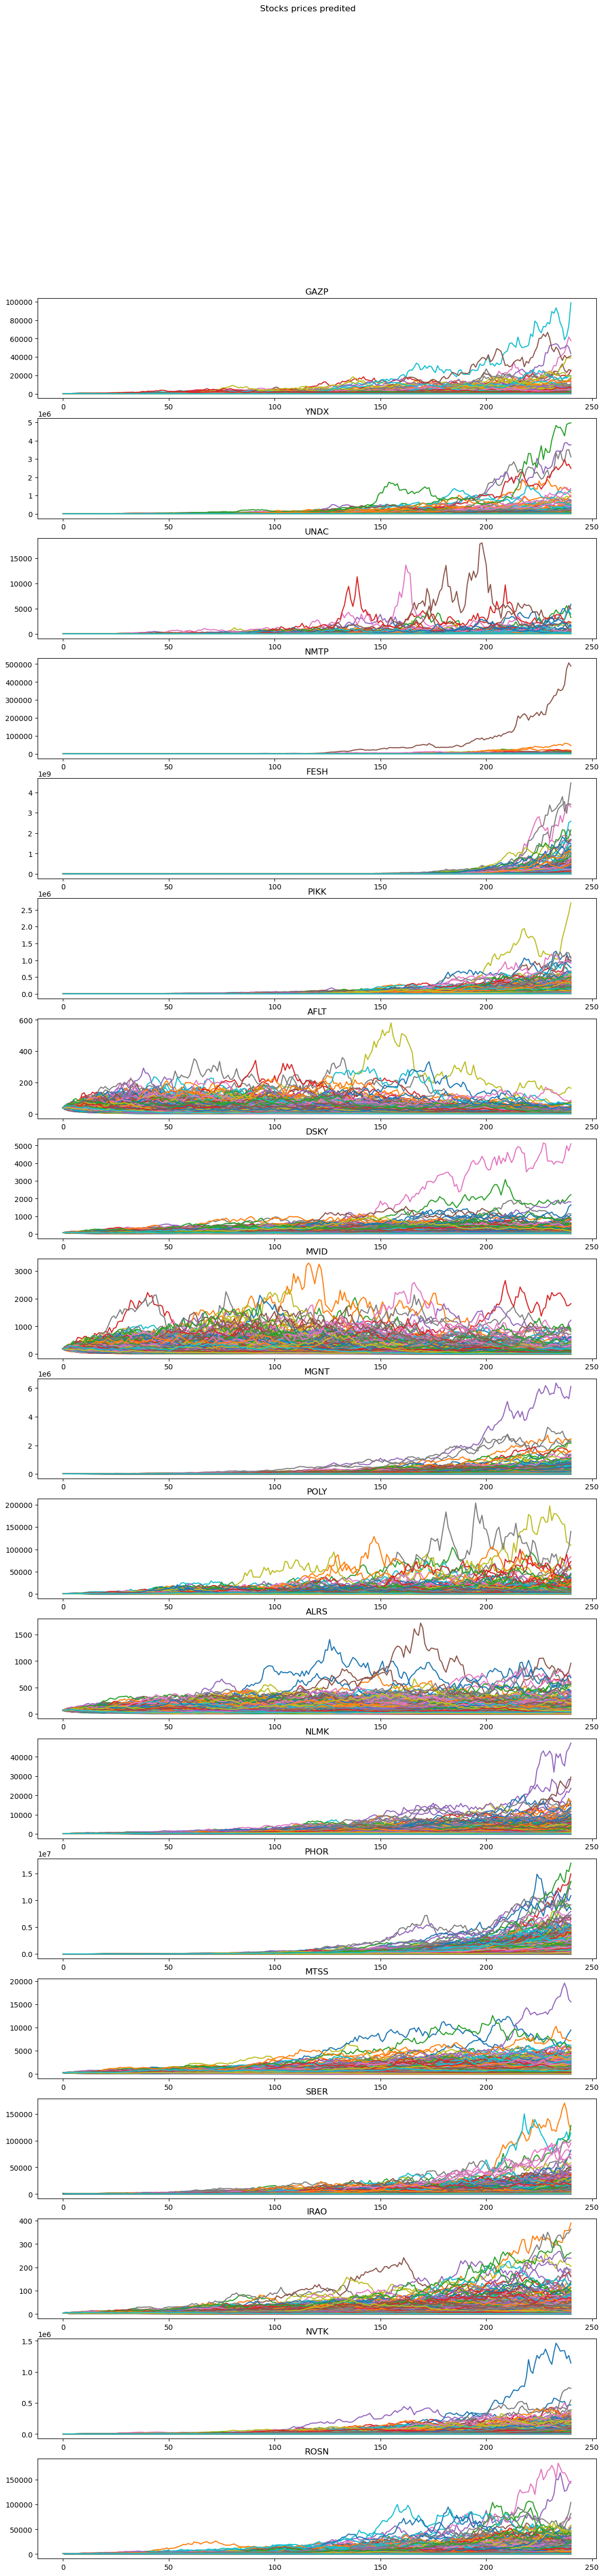

In [9]:
fig, axs = plt.subplots(stocks_number)
fig.set_size_inches(14, stocks_number * 3)
fig.suptitle('Stocks prices predited')
for stock_number in range(stocks_number):
    axs[stock_number].set_title(stock_tickers[stock_number])
    axs[stock_number].plot(prices_predicted[:, stock_number, :].T)

# Вычисление распределения доходностей нашего портфеля

In [17]:
def static_rebalance(current_assets: list,
                     current_prices: list,
                     proportions: list,
                     cash_flow: float) -> list:
    
    """This function takes lists of current assets (number of each), 
    their current prices, needed proportions of values (estimated through theory),
    and cash flow (deposit or withdraw).
    It rerurns the list of rebalanced numbers of each asset"""
    
    # len of all lists should be the same
    if (len(current_assets) != len(current_prices)) or (len(current_assets) != len(proportions)):
        raise ValueError('All lists should have same size')
    
    # calculating total value of our current shares
    total_value = 0
    for i in range(len(current_assets)):
        total_value += current_assets[i] * current_prices[i]
    
    # add deposit/withdraw
    total_value += cash_flow
    if total_value < 0:
        raise ValueError('Too big withdraw')
    
    # calculating new numbers
    rebalanced_assets = []
    for i in range(len(proportions)):
        rebalanced_assets.append(total_value * proportions[i] / current_prices[i])
        
    return rebalanced_assets

def total_value_func(current_assets: list, current_prices: list) -> float:
    total_value = 0
    for i in range(len(current_assets)):
        total_value += current_assets[i] * current_prices[i]
    return total_value

In [18]:
df_assets_monthly

,GAZP,YNDX,UNAC,NMTP,FESH,PIKK,AFLT,DSKY,MVID,MGNT,POLY,ALRS,NLMK,PHOR,MTSS,SBER,IRAO,NVTK,ROSN
TRADEDATE,,,,,,,,,,,,,,,,,,,
2018-10-31,155.47,1916.5,0.8090,6.135,4.990,352.3,97.25,89.50,398.5,3590.0,608.0,99.90,160.42,2470.0,257.60,189.80,3.9820,1049.8,460.45
2018-11-30,161.29,1965.0,0.7760,6.830,4.925,351.1,114.40,93.50,418.2,3500.0,667.3,99.63,158.36,2593.0,247.55,194.00,4.0950,1127.2,423.10
2018-12-29,153.50,1930.0,0.7880,6.850,4.710,376.3,101.18,90.44,410.0,3511.5,731.2,98.62,157.42,2546.0,238.00,186.30,3.8795,1132.0,432.50
2019-01-31,162.82,2212.0,0.8070,6.920,5.495,352.0,107.92,90.90,400.6,4155.0,746.9,98.56,152.02,2583.0,260.75,217.90,3.8250,1145.0,411.25
2019-02-28,158.99,2208.0,0.7030,7.450,5.065,359.0,97.10,88.92,412.0,3780.0,778.0,95.10,158.44,2555.0,253.00,207.80,3.9150,1080.4,398.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,166.86,2439.6,0.7515,9.770,66.250,758.3,42.70,71.26,190.2,5156.0,523.4,70.30,172.74,7310.0,296.75,239.61,4.0370,1335.0,482.35
2023-07-31,174.33,2635.0,0.7780,10.275,88.100,783.9,45.63,70.58,218.3,5797.5,NaN,85.50,211.44,7548.0,290.10,267.40,4.1605,1519.4,508.75
2023-08-31,177.99,2689.0,1.9895,15.100,109.440,827.0,44.02,68.18,196.0,6080.0,NaN,81.27,204.30,7314.0,284.10,264.85,4.1920,1684.8,556.15


In [19]:
start_assets = {}
needed_proportions = []
for one_ticker in stock_tickers:
    start_assets[one_ticker] = 0
    needed_proportions.append(cleaned_opt_weights[one_ticker])
    
# потом будет импортировать эти числа из икселя
cash_list = pd.read_csv('nominal_cashflows.csv')['cashflow'].to_list()

In [20]:
if len(prices_predicted[0][0]) != len(cash_list):
    raise ValueError("Cash flow and Asset price vectors should have same size") 

monthly_values = []
final_values = []
    
for one_traj in tqdm(range(len(prices_predicted))):
    one_traj_monthly = []
    assets_amounts = list(start_assets.values())
    assets_tickers = list(start_assets.keys())
    for one_date in range(len(cash_list)):

        #get cashflow for this date
        cashflow = cash_list[one_date]

        #get current assets prices
        c_prices = []
        for one_asset in range(len(assets_tickers)):
            
            one_price = prices_predicted[one_traj][one_asset][one_date]
            c_prices.append(one_price)

        assets_amounts = static_rebalance(assets_amounts, c_prices, needed_proportions, cashflow)
        total_value = total_value_func(assets_amounts, c_prices)
        
        one_traj_monthly.append(total_value)
        
    monthly_values.append(one_traj_monthly)
    final_values.append(total_value)
        

100%|██████████| 5000/5000 [00:51<00:00, 96.38it/s] 


c:\Users\Anton\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Anton\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


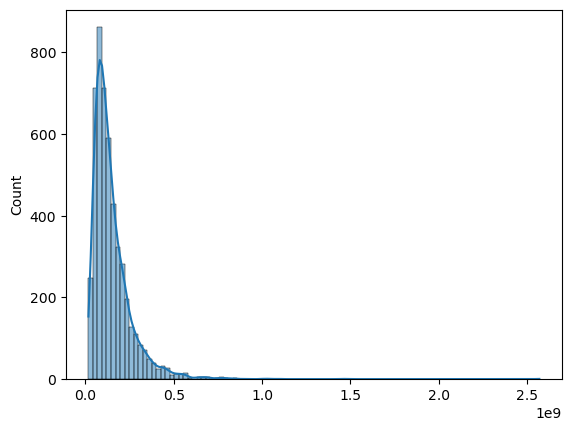

In [21]:
sns.histplot(final_values, kde=True, bins = 100);

In [22]:
result_values = pd.DataFrame()
result_values['result_value'] = final_values
result_values.describe()

,result_value
count,5.000000e+03
mean,1.490427e+08
std,1.140962e+08
min,1.771295e+07
25%,7.803393e+07
50%,1.186815e+08
75%,1.869486e+08
max,2.568863e+09


## Risk free

In [25]:
riskfree_price = [1]
# one_m = ((1 + 11.92 / 100)**20 - 1) / 240
one_m = ((1 +  11.92/ 100)**20 - 1) / 240
for i in range(240):
    riskfree_price.append(riskfree_price[-1] + one_m)

In [26]:
cash_list = pd.read_csv('nominal_cashflows.csv')['cashflow'].to_list()

In [27]:
# когда инвестируем все в риск-фри
needed_proportions = [1]
assets_amounts = [0]
one_traj_monthly = []
for one_date in range(len(riskfree_price)):

    #get cashflow for this date
    cashflow = cash_list[one_date]

    #get current assets prices
    c_prices = [riskfree_price[one_date]]

    assets_amounts = static_rebalance(assets_amounts, c_prices, needed_proportions, cashflow)
    total_value = total_value_func(assets_amounts, c_prices)

    one_traj_monthly.append(total_value)
    

In [28]:
one_traj_monthly[-1]

67506864.37554234

In [33]:
for i in np.linspace(0, 1, 1001):
    if np.quantile(result_values, i) >= one_traj_monthly[-1]:
        print(f'Risk free income is the {i * 100}% quntile of the stock portfolio income') 
        break

Risk free income is the 18.5% quntile of the stock portfolio income
